In [25]:
%matplotlib ipympl

from experimental.beacon_sim.experiment_results_pb2 import ExperimentResult
from experimental.beacon_sim.world_map_config_pb2 import WorldMapConfig
from experimental.beacon_sim.mapped_landmarks_pb2 import MappedLandmarks
import planning.probabilistic_road_map_python as prmp

import pandas as pd
import pandas.io.formats.style

from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets
import matplotlib as mpl
import re

mpl.style.use('ggplot')

import seaborn as sns

from pathlib import Path

import numpy as np

In [26]:
results_dir = Path('/home/rrg/Desktop/david_results/')
configs_dir = Path('/home/rrg/Desktop/david_configs/')
results_files = sorted(results_dir.glob("*.pb"))

protos_by_exp = {}
configs_by_exp = {}

for f in results_files:
    with open(f, 'rb') as file_in:
        data = ExperimentResult()
        data.ParseFromString(file_in.read())
        protos_by_exp[f.stem] = data

        map_config_path = configs_dir / f.stem / data.experiment_config.map_config_path
        road_map_path = configs_dir / f.stem / data.experiment_config.road_map_path
        mapped_landmark_path = configs_dir / f.stem / data.experiment_config.ekf_state_path

        wmc = WorldMapConfig()
        wmc.ParseFromString(map_config_path.read_bytes())

        assert road_map_path.exists()
        map_proto = MappedLandmarks()
        map_proto.ParseFromString(mapped_landmark_path.read_bytes())
        configs_by_exp[f.stem] = {
            'road_map': prmp.RoadMap.from_proto_string(road_map_path.read_bytes()),
            'world_map_config': wmc,
            'mapped_landmarks': map_proto,
        }

In [27]:
def protobuf_to_df(pb):
    out = defaultdict(list)
    i = 0
    for result in pb.results:
        planner_name = pb.planner_names[result.planner_id]
        m = re.match(r"^David Planner (\w+) (FG)-(\d+\.\d+)",planner_name)
        out['planner_type'].append('Planner '+m.group(1))
        out['planner_size'].append(None)
        out['favor_goal'].append(m.group(3))
        out['elapsed_time'].append(result.elapsed_time.count / 1e9)
        out['trial_id'].append(result.trial_id)
        out['planner_id'].append(result.planner_id)
        out['planner_name'].append(planner_name)
        out['start'].append(np.array(pb.start_goal[result.trial_id].start.data))
        out['goal'].append(np.array(pb.start_goal[result.trial_id].goal.data))
        out['timeout'].append(pb.experiment_config.plan_timeout_s)
        if result.HasField('plan'):
            out['plan'].append(list(result.plan.nodes))
            out['log_prob_mass'].append(result.plan.log_prob_mass)
            out['expected_det'].append(result.plan.expected_det)
        else:
            out['plan'].append(None)
            out['log_prob_mass'].append(None)
            out['expected_det'].append(None)
    return pd.DataFrame(out)

def extract_clusters_from_potential(potential_proto):
    
    potential_case = potential_proto.WhichOneof('potential_oneof')
    if potential_case in ['correlated_beacon_potential', 'anticorrelated_potential', 'precision_matrix_potential']:
        return [list(getattr(potential_proto, potential_case).members)]  
    elif potential_case == 'combined_potential':
        out = []
        for pot in potential_proto.combined_potential.potentials:
            out.extend(extract_clusters_from_potential(pot))
        return out
    print('unknown potential type', potential_case)
    raise NotImplementedError
    ...

def plot_mapped_landmarks(mapped_landmarks, potential_proto):
    # extract clusters from potential
    clusters = extract_clusters_from_potential(potential_proto)
    
    ids = list(mapped_landmarks.beacon_ids)
    for cluster in clusters:
        xs = []
        ys = []
        for beacon_id in cluster:
            idx = ids.index(beacon_id)
            beacon_in_map = mapped_landmarks.beacon_in_local[idx]
            xs.append(beacon_in_map.data[0])
            ys.append(beacon_in_map.data[1])
            # plt.text(beacon_in_map.data[0], beacon_in_map.data[1], f't_{ids[i]}')
        plt.plot(xs, ys, 'o')

def plot_road_map(road_map):
    pts = np.stack(road_map.points())
    plt.plot(pts[:, 0], pts[:, 1], '*')
    for i, pt in enumerate(pts):
        plt.text(*pt, str(i))

    if road_map.has_start_goal():
        for idx, marker in [(road_map.START_IDX, 'rs'), (road_map.GOAL_IDX, 'y*')]:
            pt = road_map.point(idx)
            plt.plot(*pt, marker)
            

    line_segments = []
    for i in range(len(pts)):
        for j in range(i+1, len(pts)):
            if road_map.adj()[i, j] != 0:
                line_segments.append([pts[i, :], pts[j,:]])

    if road_map.has_start_goal():
        for idx in [road_map.START_IDX, road_map.GOAL_IDX]:
            pt = road_map.point(idx)
            neighbors = road_map.neighbors(idx)
            for _, neighbor_pt in neighbors:
                line_segments.append([pt, neighbor_pt])
    

    edges = mpl.collections.LineCollection(line_segments, colors=(0.6, 0.8, 0.6, 1.0))
    ax = plt.gca()
    ax.add_collection(edges)

def plot_plan(road_map, execution_df):
    pts = [execution_df['start'].iloc[0]]
    pts += [road_map.point(x) for x in execution_df.plan.iloc[0] if x >=0]
    pts.append(execution_df['goal'].iloc[0])
    pts = np.vstack(pts)

    plt.plot(pts[:, 0], pts[:, 1], 'm')
    plt.plot(pts[0, 0], pts[0, 1], 'gs')
    plt.plot(pts[-1, 0], pts[-1, 1], 'rv')
    ...

        

In [28]:
sub_dfs = []
for name, proto in protos_by_exp.items():
    sub_df = protobuf_to_df(proto)
    sub_df['exp_name'] = name
    sub_df['exp_type'] = name.split('_')[0]
    sub_dfs.append(sub_df)
df = pd.concat(sub_dfs)
df.reset_index(inplace=True)

In [29]:
def make_plots(df, cdf_fig, pdf_fig, exec_time_fig):
    bins = np.linspace(0, 3, 1000)
    plt.figure(cdf_fig)
    plt.subplot(121)
    plt.cla()
    for i, g in df.groupby('planner_id'):
        plt.hist(g['expected_det'], density=True, histtype='step', label=g['planner_name'].iloc[0], bins=bins, cumulative=True)
        
    plt.xlabel('Expected Determinant')
    plt.ylabel('Fraction')
    plt.legend()
    plt.suptitle(df["exp_name"].iloc[0])
    plt.tight_layout()
    

    plt.figure(pdf_fig)
    ax = plt.gca()
    plt.cla()
    axes = df.plot.hist(by='planner_name', column='expected_det', bins=50, ax=ax)
    axes[-1].set_xlabel('Expected Determinant')
    plt.suptitle('Expected Determinant')
    plt.tight_layout()
    
    plt.figure(exec_time_fig)
    ax = plt.gca()
    plt.cla()
    axes = df.plot.hist(by='planner_name', column='elapsed_time', bins=50, ax=ax)
    for i, ax in enumerate(axes):
        ax.set_yscale('log')

    axes[-1].set_xlabel('Elapsed Time (s)')
    plt.suptitle('Elasped Time')
    plt.tight_layout()

def make_trial_plot(trial_fig, trial_df):
    plt.figure(trial_fig)
    plt.subplot(122)
    plt.cla()
    exp_name = trial_df['exp_name'].iloc[0]
    exp_configs = configs_by_exp[exp_name]
    plot_mapped_landmarks(exp_configs['mapped_landmarks'], exp_configs['world_map_config'].correlated_beacons.potential)
    plot_road_map(exp_configs['road_map'])
    plot_plan(exp_configs['road_map'], trial_df)
    


def plot_overview_results(df):
    exps = np.unique(df['exp_name'])
    exp_selector = ipywidgets.Dropdown(options=exps, description='experiment:')
    trial_selector = ipywidgets.IntSlider(min=0, max=1, step=1, value=0, description='Trial Selector:', behavior='snap')
    planner_selector = ipywidgets.Dropdown(options=[], description='planner:')
    hbox = ipywidgets.HBox()
    cdf_fig = plt.figure(figsize=(16, 8))
    pdf_fig = plt.figure(figsize=(13,10))
    exec_time_fig = plt.figure(figsize=(13,10))
    # trial_fig = plt.figure(figsize=(8, 8))

    def on_trial_or_planner_change(change):
        exp_mask = df['exp_name'] == exp_selector.value
        trial_mask = df['trial_id'] == trial_selector.value
        planner_mask = df['planner_name'] == planner_selector.value
        mask = exp_mask & trial_mask
        execution_mask = mask & planner_mask

        trial_df = df[mask]
        _ = display(trial_df, display_id='trial_df')
        execution_df = df[execution_mask]
        make_trial_plot(cdf_fig, execution_df)

        
    def on_instance_change(change):
        selected_exp_name = exp_selector.value
         
        sub_df = df[df['exp_name'] == selected_exp_name]

        trial_selector.min = 0
        trial_selector.max = sub_df['trial_id'].max()
        trial_selector.value = 0

        planner_selector.options = np.unique(sub_df['planner_name'])
        planner_selector.value = planner_selector.options[0]
        
        make_plots(sub_df, cdf_fig, pdf_fig, exec_time_fig)
        on_trial_or_planner_change({})

        
    
    hbox.children=(exp_selector, trial_selector, planner_selector)

    exp_selector.observe(on_instance_change, 'value')
    trial_selector.observe(on_trial_or_planner_change, 'value')
    planner_selector.observe(on_trial_or_planner_change, 'value')
    display(hbox)
    on_instance_change({})
    
   

,index,planner_type,planner_size,favor_goal,elapsed_time,trial_id,planner_id,planner_name,start,goal,timeout,plan,log_prob_mass,expected_det,exp_name,exp_type
2208,128,Planner Two,None,1.0,1.277472,16,0,David Planner Two FG-1.0,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 62, 73, 84, 95, -2]",-70.368323,9.951993e-01,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2209,129,Planner Two,None,0.75,6.817438,16,1,David Planner Two FG-0.75,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 60, 72, 83, 95, -2]",-70.368323,1.810649e-03,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2210,130,Planner Two,None,0.5,15.075279,16,2,David Planner Two FG-0.5,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 60, 61, 73, 84, 96, 86, 98, 1...",-70.368323,6.766312e-03,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2211,131,Planner Two,None,0.25,20.518066,16,3,David Planner Two FG-0.25,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 59, 60, 61, 72, 83, 82, 92, 9...",-70.368323,4.121738e-07,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2212,132,Planner Three,None,1.0,1.022877,16,4,David Planner Three FG-1.0,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 62, 73, 84, 95, -2]",-70.368323,9.951993e-01,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2213,133,Planner Three,None,0.75,5.321294,16,5,David Planner Three FG-0.75,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 36, 48, 60, 72, 84, 95, 83, 94, 104, ...",-70.368323,5.971754e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2214,134,Planner Three,None,0.5,11.838825,16,6,David Planner Three FG-0.5,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 49, 61, 72, 83, 71, 82, 81, 8...",-70.368323,3.683378e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2215,135,Planner Three,None,0.25,14.677128,16,7,David Planner Three FG-0.25,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 15, 27, 37, 47, 48, 59, 69, 70, 80, 79, 6...",-70.368323,3.814089e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial


/tmp/ipykernel_8847/3501394880.py:19: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.plot.hist(by='planner_name', column='expected_det', bins=50, ax=ax)
/tmp/ipykernel_8847/3501394880.py:27: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axes = df.plot.hist(by='planner_name', column='elapsed_time', bins=50, ax=ax)


,index,planner_type,planner_size,favor_goal,elapsed_time,trial_id,planner_id,planner_name,start,goal,timeout,plan,log_prob_mass,expected_det,exp_name,exp_type
2208,128,Planner Two,None,1.0,1.277472,16,0,David Planner Two FG-1.0,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 62, 73, 84, 95, -2]",-70.368323,9.951993e-01,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2209,129,Planner Two,None,0.75,6.817438,16,1,David Planner Two FG-0.75,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 60, 72, 83, 95, -2]",-70.368323,1.810649e-03,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2210,130,Planner Two,None,0.5,15.075279,16,2,David Planner Two FG-0.5,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 60, 61, 73, 84, 96, 86, 98, 1...",-70.368323,6.766312e-03,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2211,131,Planner Two,None,0.25,20.518066,16,3,David Planner Two FG-0.25,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 59, 60, 61, 72, 83, 82, 92, 9...",-70.368323,4.121738e-07,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2212,132,Planner Three,None,1.0,1.022877,16,4,David Planner Three FG-1.0,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 50, 62, 73, 84, 95, -2]",-70.368323,9.951993e-01,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2213,133,Planner Three,None,0.75,5.321294,16,5,David Planner Three FG-0.75,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 36, 48, 60, 72, 84, 95, 83, 94, 104, ...",-70.368323,5.971754e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2214,134,Planner Three,None,0.5,11.838825,16,6,David Planner Three FG-0.5,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 26, 38, 48, 49, 61, 72, 83, 71, 82, 81, 8...",-70.368323,3.683378e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial
2215,135,Planner Three,None,0.25,14.677128,16,7,David Planner Three FG-0.25,"[41.712218263325866, 0.2496732986299724]","[68.82056001895938, 98.71364145944685]",60.0,"[-1, 15, 27, 37, 47, 48, 59, 69, 70, 80, 79, 6...",-70.368323,3.814089e-08,spatial_clus_dens_1.0E-03_p_beacon_0.50_p_no_b...,spatial


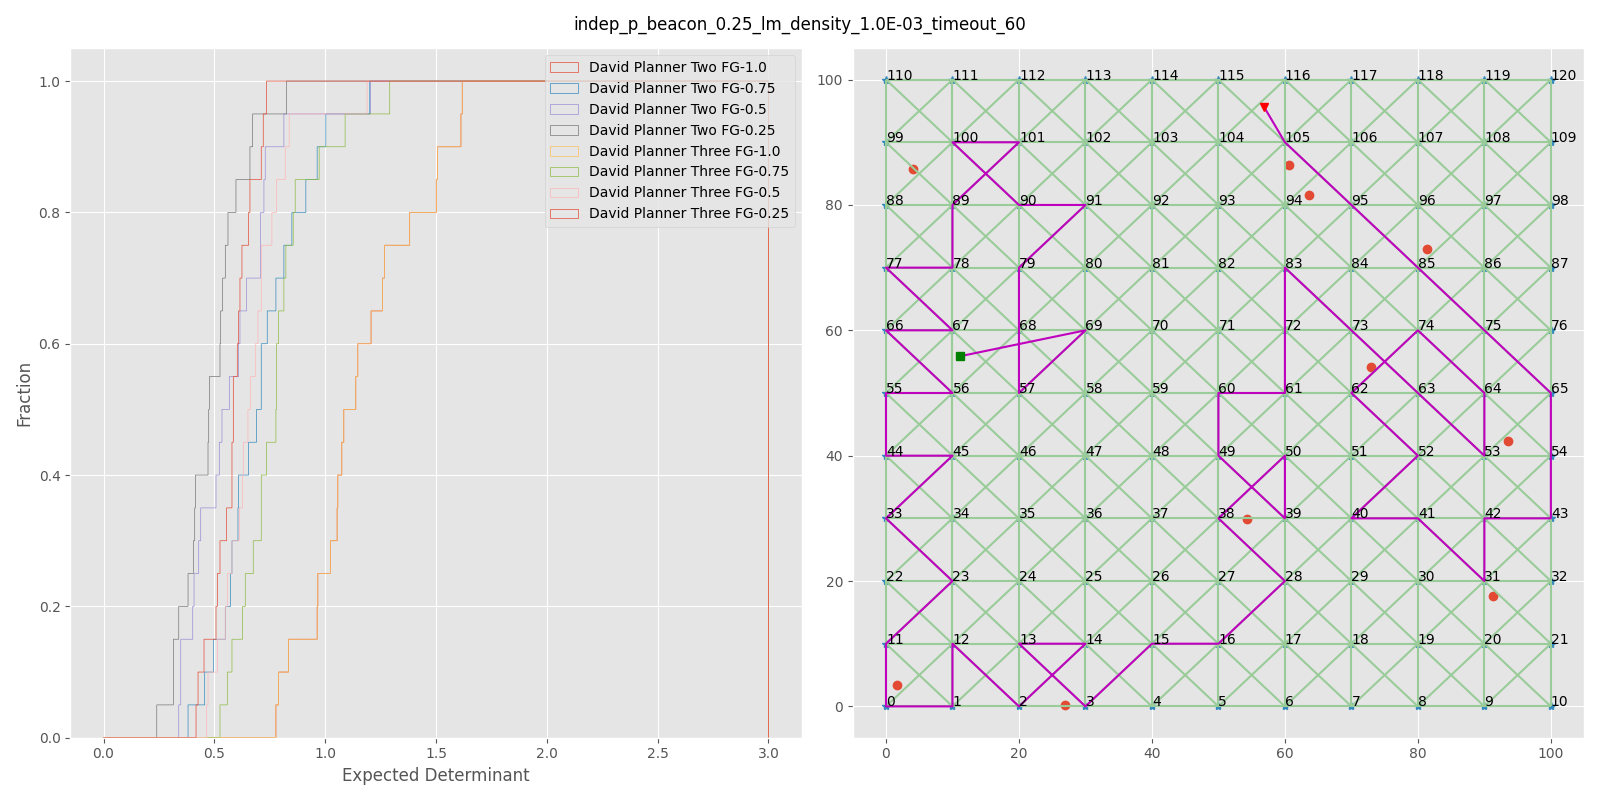

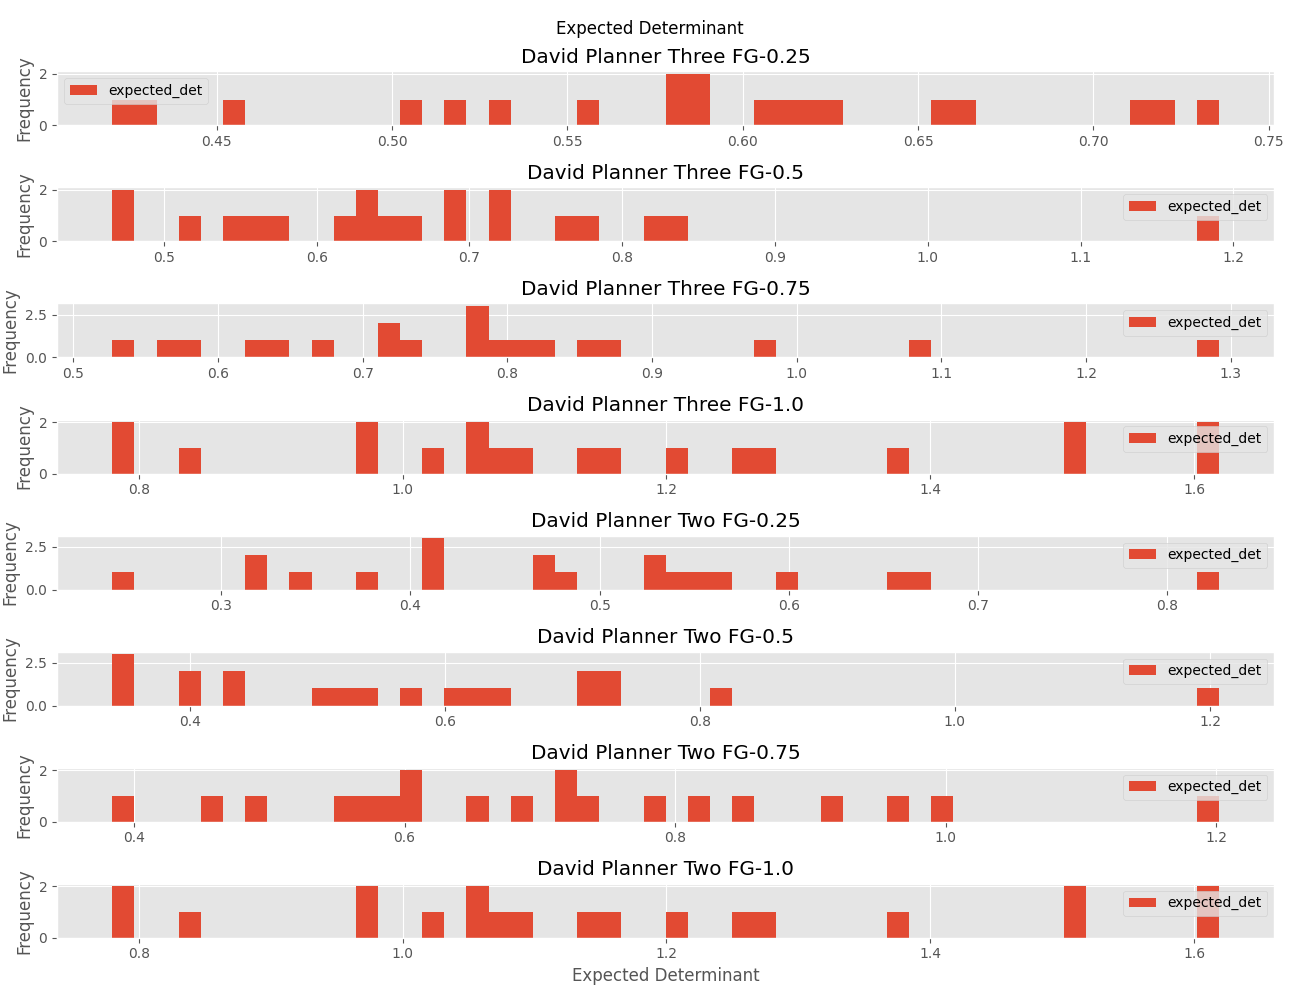

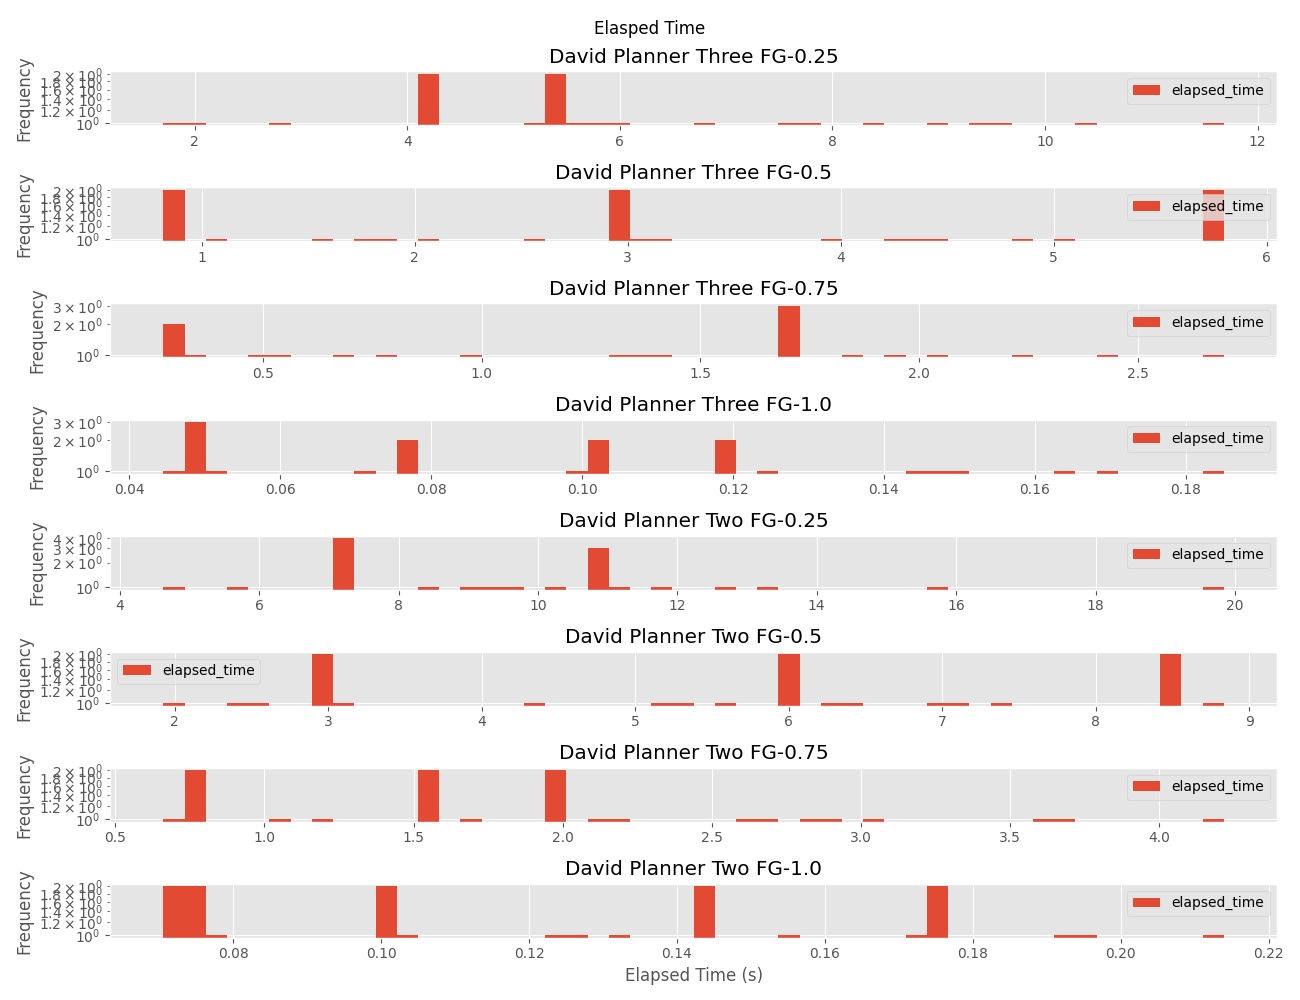

In [30]:
plot_overview_results(df)


#axes = df.plot.hist(by='planner_id', column='log_prob_mass', bins=50, figsize=(13,10))
#for i, ax in enumerate(axes):
#    ax.set_yscale('log')
#    ax.set_title(planners[i])
#axes[-1].set_xlabel('Log Prob Mass')
#plt.suptitle('Log Prob Mass')
#plt.tight_layout()

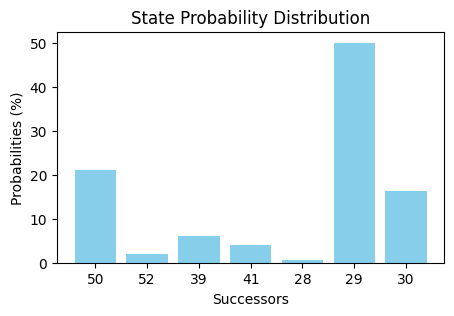

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x_values = [50,52,39,41,28,29,30]
probabilities = [21,1.9,6,4.1,0.7,50,16.3]

x_positions = np.linspace(0.5, len(x_values) - 0.5, len(x_values))

plt.figure(figsize=(5,3))
plt.bar(x_positions,probabilities,color='skyblue',width=0.8)
plt.xlabel('Successors')
plt.ylabel('Probabilities (%)')
plt.title('State Probability Distribution')
plt.xticks(ticks=x_positions, labels=x_values)

plt.show()